# SIRDT 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import deepxde as dde
import seaborn as sns

from deepxde.backend import tf
from scipy.integrate import odeint

sns.set_theme(style="darkgrid")
sns.set(rc={"figure.facecolor":"white"})

# dde.config.real.set_float64()
%matplotlib inline

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2022-07-11 23:30:36.732611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-11 23:30:36.769124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-11 23:30:36.769462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


$$
\begin{aligned}
\frac{dS_1}{dt} &= - \frac{\beta_1}{N_1}  S_1 I_1 - \tau_{1,2} S_1 + \tau_{2,1} S_2 \\
\frac{dI_1}{dt} &= \frac{\beta_1}{N_1} S_1 I_1 - \gamma_1  I_1 - \mu_1 I_1  - \tau_{1,2} I_1 + \tau_{2,1} I_2\\
\frac{dR_1}{dt} &= \gamma_1 I_1 - \tau_{1,2} R_1 + \tau_{2,1} R_2\\
\frac{dD_1}{dt} &= \mu_1 I_1 \\
\\
\frac{dS_2}{dt} &= - \frac{\beta_2}{N_2}  S_2 I_2 - \tau_{2,1} S_2 + \tau_{1,2} S_1 \\
\frac{dI_2}{dt} &= \frac{\beta_2}{N_2} S_2 I_2 - \gamma_2  I_2 - \mu_2 I_2  - \tau_{2,1} I_2 + \tau_{1,2} I_1\\
\frac{dR_2}{dt} &= \gamma_2 I_2 - \tau_{2,1} R_2 + \tau_{1,2} R_1\\
\frac{dD_2}{dt} &= \mu_2 I_2
\end{aligned}
$$

where $\beta ,\gamma ,\mu$  are the rates of infection, recovery, and mortality, respectively.

## Initial Conditions

In [2]:
N1 = 1e7
S1_0 = N1 - 1000
I1_0 = 1000
R1_0 = 0
D1_0 = 0

N2 = 7e6
S2_0 = N2 - 1000
I2_0 = 1000
R2_0 = 0
D2_0 = 0

beta1 = 0.45
gamma1 = 0.05
mu1 = 0.0294
beta2 = 0.4
gamma2 = 0.05
mu2 = 0.0294
t12 = 0.02
t21 = 0.01

parameters_real = [
  beta1,
  gamma1,
  mu1,
  beta2,
  gamma2,
  mu2,
  t12,
  t21
]

t = np.arange(0, 300, 10)[:, np.newaxis]

## Generate Data

In [3]:
def sirdt_model(
    t,
    N1,
    N2,
    beta1,
    gamma1,
    mu1,
    beta2,
    gamma2,
    mu2,
    t12,
    t21
):
    def func(y, t):
        S1, I1, R1, D1, S2, I2, R2, D2 = y
        return [
            - beta1 / N1 * S1 * I1 - t12 * S1 + t21 * S2,
            beta1 / N1 * S1 * I1 - gamma1 * I1 - mu1 * I1 - t12 * I1 + t21 * I2,
            gamma1 * I1 - t12 * R1 + t21 * R2,
            mu1 * I1,
            - beta2 / N2 * S2 * I2 - t21 * S2 + t12 * S1,
            beta2 / N2 * S2 * I2 - gamma2 * I2 - mu2 * I2  - t21 * I2 + t12 * I1,
            gamma2 * I2 - t21 * R2 + t12 * R1,
            mu2 * I2
        ]
    
    S1_0 = N1 - 1000
    I1_0 = 1000
    R1_0 = 0
    D1_0 = 0
    S2_0 = N2 - 1000
    I2_0 = 1000
    R2_0 = 0
    D2_0 = 0
    y0 = [S1_0, I1_0, R1_0, D1_0, S2_0, I2_0, R2_0, D2_0]
    return odeint(func, y0, t)

In [4]:
y = sirdt_model(np.ravel(t), N1, N2, beta1, gamma1, mu1, beta2, gamma2, mu2, t12, t21)

In [5]:
y_noise1 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.01
y_noise5 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.05
y_noise10 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.1

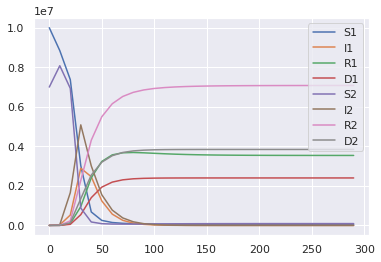

In [6]:
names = ["S1", "I1", "R1", "D1", "S2", "I2", "R2", "D2"]
for v, name in zip(y.T, names):
    plt.plot(np.ravel(t), v, label=name)
plt.legend()
plt.show()

## DINN

In [7]:
def dinn(data_t, data_y, N1, N2):    
    
    # Variables
    beta1 = tf.math.sigmoid(dde.Variable(0.1))
    gamma1 = tf.math.sigmoid(dde.Variable(0.1))
    mu1 = tf.math.sigmoid(dde.Variable(0.1))
    beta2 = tf.math.sigmoid(dde.Variable(0.1))
    gamma2 = tf.math.sigmoid(dde.Variable(0.1))
    mu2 = tf.math.sigmoid(dde.Variable(0.1))
    t12 = tf.math.sigmoid(dde.Variable(0.1)) * 0.1
    t21 = tf.math.sigmoid(dde.Variable(0.1)) * 0.1
    variable_list = [beta1, gamma1, mu1, beta2, gamma2, mu2, t12, t21]

    # ODE model
    def ODE(t, y):
        S1 = y[:, 0:1]
        I1 = y[:, 1:2]
        R1 = y[:, 2:3]
        D1 = y[:, 3:4]
        S2 = y[:, 4:5]
        I2 = y[:, 5:6]
        R2 = y[:, 6:7]
        D2 = y[:, 7:8]
        
        dS1_t = dde.grad.jacobian(y, t, i=0)
        dI1_t = dde.grad.jacobian(y, t, i=1)
        dR1_t = dde.grad.jacobian(y, t, i=2)
        dD1_t = dde.grad.jacobian(y, t, i=3)
        dS2_t = dde.grad.jacobian(y, t, i=4)
        dI2_t = dde.grad.jacobian(y, t, i=5)
        dR2_t = dde.grad.jacobian(y, t, i=6)
        dD2_t = dde.grad.jacobian(y, t, i=7)
        
        return [
            dS1_t - (- beta1 / N1 * S1 * I1 - t12 * S1 + t21 * S2),
            dI1_t - (beta1 / N1 * S1 * I1 - gamma1 * I1 - mu1 * I1 - t12 * I1 + t21 * I2),
            dR1_t - (gamma1 * I1 - t12 * R1 + t21 * R2),
            dD1_t - (mu1 * I1),
            dS2_t - (- beta2 / N2 * S2 * I2 - t21 * S2 + t12 * S1),
            dI2_t - (beta2 / N2 * S2 * I2 - gamma2 * I2 - mu2 * I2  - t21 * I2 + t12 * I1),
            dR2_t - (gamma2 * I2 - t21 * R2 + t12 * R1),
            dD2_t - (mu2 * I2)
        ]
    
    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])
    
    # Boundaries
    def boundary(_, on_initial):
        return on_initial
    
    # Initial conditions
    ic_S1 = dde.icbc.IC(geom, lambda x: N1- 1000, boundary, component=0)
    ic_I1 = dde.icbc.IC(geom, lambda x: 1000, boundary, component=1)
    ic_R1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=2)
    ic_D1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=3)
    ic_S2 = dde.icbc.IC(geom, lambda x: N2- 1000, boundary, component=4)
    ic_I2 = dde.icbc.IC(geom, lambda x: 1000, boundary, component=5)
    ic_R2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=6)
    ic_D2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=7)

    # Train data
    observe_S1 = dde.icbc.PointSetBC(data_t, data_y[:, 0:1], component=0)
    observe_I1 = dde.icbc.PointSetBC(data_t, data_y[:, 1:2], component=1)
    observe_R1 = dde.icbc.PointSetBC(data_t, data_y[:, 2:3], component=2)
    observe_D1 = dde.icbc.PointSetBC(data_t, data_y[:, 3:4], component=3)
    observe_S2 = dde.icbc.PointSetBC(data_t, data_y[:, 4:5], component=4)
    observe_I2 = dde.icbc.PointSetBC(data_t, data_y[:, 5:6], component=5)
    observe_R2 = dde.icbc.PointSetBC(data_t, data_y[:, 6:7], component=6)
    observe_D2 = dde.icbc.PointSetBC(data_t, data_y[:, 7:8], component=7)
    
    # Model
    data = dde.data.PDE(
        geom,
        ODE,
        [
            ic_S1,
            ic_I1,
            ic_R1,
            ic_D1,
            ic_S2,
            ic_I2,
            ic_R2,
            ic_D2,
            observe_S1,
            observe_I1,
            observe_R1,
            observe_D1,
            observe_S2,
            observe_I2,
            observe_R2,
            observe_D2
        ],
        num_domain=400,
        num_boundary=2,
        anchors=data_t,
    )
    
    net = dde.nn.FNN([1] + [128] * 3 + [8], "relu", "Glorot uniform")
    
    def feature_transform(t):
        t = t / data_t[-1, 0]
        return t

    net.apply_feature_transform(feature_transform)
    
    iterations = 100000
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=8 * [1] + 8 * [2] + 8 * [6],
        external_trainable_variables=variable_list
    )
    variable = dde.callbacks.VariableValue(
        variable_list,
        period=5000,
        filename="variables_sirdt.dat"
    )
    losshistory, train_state = model.train(
        iterations=iterations,
        display_every=5000,
        callbacks=[variable]
    )
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    return model, variable, losshistory, train_state

Compiling model...
Building feed-forward neural network...
'build' took 0.033755 s



/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "
/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-07-11 23:30:37.729090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-11 23:30:37.732690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] cou

'compile' took 1.632025 s

Initializing variables...
Training model...



2022-07-11 23:30:39.350242: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-07-11 23:30:39.408081: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f6970012d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-07-11 23:30:39.408128: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2022-07-11 23:30:39.446093: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-11 23:30:39.475533: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-07-11 23:30:39.552537: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Step      Train loss                                                                                                                                                                                                                                          Test loss                                                                                                                                                                                                                                           Test metric
0         [6.90e-07, 5.40e-04, 1.95e-04, 1.15e-04, 6.83e-07, 1.19e-04, 5.97e-05, 2.51e-05, 2.00e+14, 2.00e+06, 0.00e+00, 0.00e+00, 9.80e+13, 2.00e+06, 0.00e+00, 0.00e+00, 4.85e+13, 3.33e+12, 6.48e+13, 2.85e+13, 3.27e+13, 8.17e+12, 2.44e+14, 7.37e+13]    [6.90e-07, 5.40e-04, 1.95e-04, 1.15e-04, 6.83e-07, 1.19e-04, 5.97e-05, 2.51e-05, 2.00e+14, 2.00e+06, 0.00e+00, 0.00e+00, 9.80e+13, 2.00e+06, 0.00e+00, 0.00e+00, 4.85e+13, 3.33e+12, 6.48e+13, 2.85e+13, 3.27e+13, 8.17e+12, 2.44e+14, 7.37e

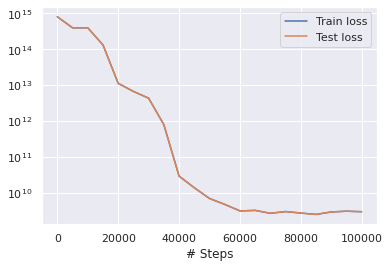

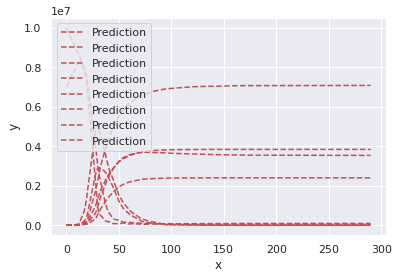

In [8]:
model, variable, losshistory, train_state = dinn(t, y, N1, N2)

## Postprocessing

In [9]:
parameter_names = [
  "beta1",
  "gamma1",
  "mu1",
  "beta2",
  "gamma2",
  "mu2",
  "t12",
  "t21"
]
errors = (
    pd.DataFrame(
        {
            "real": parameters_real,
            "predicted": variable.value
        },
        index=parameter_names
    )
    .assign(
        relative_error=lambda x: (x["real"] - x["predicted"]).abs() / x["real"] * 100
    )
)
errors.to_excel("SIRDT_errors.xlsx")
errors

,real,predicted,relative_error
beta1,0.4500,0.424615,5.641192
gamma1,0.0500,0.050254,0.508600
mu1,0.0294,0.029581,0.615605
beta2,0.4000,0.355218,11.195397
gamma2,0.0500,0.048680,2.640499
mu2,0.0294,0.027588,6.162453
t12,0.0200,0.018560,7.199414
t21,0.0100,0.009050,9.496568


In [10]:
print(
    errors.style
    .format(
        {
            "real": "{:.4f}",
            "predicted": "{:.4f}",
            "relative_error": "{:.2f}",
        }
    ).to_latex(
        label="tab:sirdt_errors",
        caption="Parameter predictions and relative errors.",   
    )
)

\begin{table}
\caption{Parameter predictions and relative errors.}
\label{tab:sirdt_errors}
\begin{tabular}{lrrr}
 & real & predicted & relative_error \\
beta1 & 0.4500 & 0.4246 & 5.64 \\
gamma1 & 0.0500 & 0.0503 & 0.51 \\
mu1 & 0.0294 & 0.0296 & 0.62 \\
beta2 & 0.4000 & 0.3552 & 11.20 \\
gamma2 & 0.0500 & 0.0487 & 2.64 \\
mu2 & 0.0294 & 0.0276 & 6.16 \\
t12 & 0.0200 & 0.0186 & 7.20 \\
t21 & 0.0100 & 0.0091 & 9.50 \\
\end{tabular}
\end{table}



In [11]:
df_real = (
    pd.DataFrame(y, columns=names, index=t.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status_region", value_name="population")
    .assign(
        status=lambda x: x["status_region"].str[0],
        region=lambda x: x["status_region"].str[1],
    )
)

t_pred = np.arange(0, 300)[:, np.newaxis]
y_pred = model.predict(t_pred)
df_pred = (
    pd.DataFrame(y_pred, columns=names, index=t_pred.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status_region", value_name="population")
    .assign(
        status=lambda x: x["status_region"].str[0],
        region=lambda x: x["status_region"].str[1],
    )
)
df_pred.head()

,time,status_region,population,status,region
0,0,S1,9998859.0,S,1
1,1,S1,9883025.0,S,1
2,2,S1,9767477.0,S,1
3,3,S1,9651933.0,S,1
4,4,S1,9536387.0,S,1


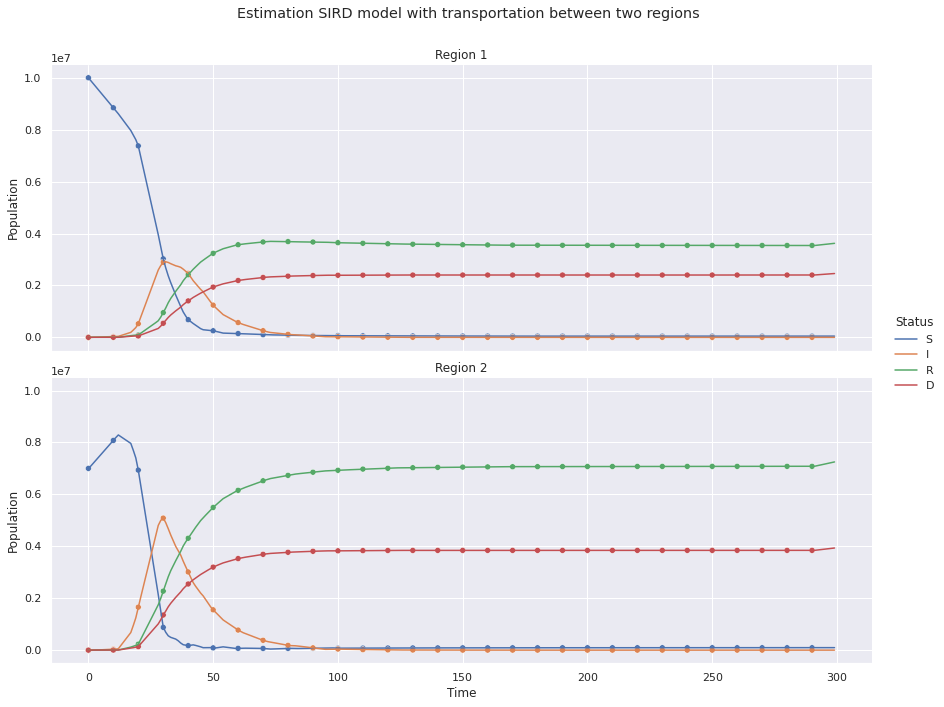

In [12]:
sns.set(rc={"figure.facecolor":"white"})

g = sns.relplot(
    data=df_pred,
    x="time",
    y="population",
    row="region",
    hue="status",
    kind="line",
    aspect=2.5,
)

for region, ax in g.axes_dict.items():
    sns.scatterplot(
        data=df_real.query("region == @region"),
        x="time",
        y="population",
        hue="status",
        ax=ax,
        legend=False
    )


(
    g.set_axis_labels("Time", "Population")
      .set_titles("Region {row_name}")
      .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"Estimation SIRD model with transportation between two regions")
plt.savefig("SIRDT_estimation.png", dpi=300)
plt.show()